In [1]:
import pandas as pd
import os

from mxnet import autograd, np, npx 
npx.set_np()

In [2]:
from matplotlib import pyplot as plt

# 定义绘图相关函数
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.""" 
    # display.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(7, 5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, 
         xscale='linear', yscale='linear',fmts=('-', 'm--', 'g-.', 'r:'), figsize=(7, 5), axes=None
    ):
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if X (ndarray or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    plt.show()

#  02. Preliminaries
All machine learning is concerned with extracting information from data. So we will begin by learning the practical skills for storing, manipulating, and preprocessing data.

Moreover, machine learning typically requires working with large datasets, which we can think of as tables, where the rows correspond to examples and the columns correspond to attributes. Linear algebra gives us a powerful set of techniques for working with tabular data. We will not go too far into the weeds but rather focus on the basic of matrix operations and their implementation.

Additionally, deep learning is all about optimization. We have a model with some parameters and we want to find those that fit our data the best. Determining which way to move each parameter at each step of an algorithm requires a little bit of calculus, which will be briefly introduced. Fortunately, the autograd package automatically computes differentiation for us, and we will cover it next.

Next, machine learning is concerned with making predictions: what is the likely value of some unknown attribute, given the information that we observe? To reason rigorously under uncertainty we will need to invoke the language of probability.

In the end, the official documentation provides plenty of descriptions and examples that are beyond this book. To conclude the chapter, we will show you how to look up documentation for the needed information.

This book has kept the mathematical content to the minimum necessary to get a proper understanding of deep learning. However, it does not mean that this book is mathematics free. Thus, this chapter provides a rapid introduction to basic and frequently-used mathematics to allow anyone to understand at least most of the mathematical content of the book. If you wish to understand all of the mathematical content, further reviewing `Chapter 18` should be sufficient.


## 2.1 Data Manipulation
In order to get anything done, we need some way to store and manipulate data. We introduce the $n$-dimensional array(ndarray), MXNet's primary tool for storing and transforming data. In MXNet, `ndarray` is a class and we call any instance "an ndarray".

If you have worked with `NumPy`, then you will find this section familiar. That's by design. We designed MXNet's `ndarray` to be an extension to NumPy's `ndarray` with a few killer features:
+ First, MXNet's `ndarray` supports asynchronous computation on CPU, GPU, and distributed cloud architectures, whereas NumPy only supports CPU computation
+ Second, MXNet's `ndarray` supports automatic differentiation

These properties make MXNet's `ndarray` suitable for deep learning. Throughout the book, when we say `ndarray`, we are referring to MXNet's `ndarray` unless otherwise stated.

### 2.1.1 Getting Started
In this section, we aim to get you up and running, equipping you with the basic math and numerical computing tools that you will build on as you progress through the book. Do not worry if you struggle to grok some of the mathematical concepts or library functions. The following sections will revisit this material in the context of practical examples and it will sink. On the other hand, if you already have some background and want to go deeper into the mathematical content, just skip this section.

To start, we import the `np` (numpy) and `npx` (numpy_extension) modules from MXNet:
+ `np` module includes functions supported by `NumPy`
+ `npx` module contains a set of extensions developed to empower deep learning within a NumPy-like environment

> **[NOTE]**
>
> When using `ndarray`, we almost always invoke the `set_np` function: this is for compatibility of `ndarray` processing by other components of MXNet.

```python
from mxnet import np, npx 
npx.set_np()
```

An `ndarray` represents a (possibly multi-dimensional) array of numerical values:
+ With one axis, an `ndarray` corresponds (in math) to a **vector**
+ With two axes, an `ndarray` corresponds to a **matrix**
+ Arrays with more than two axes do not have special mathematical names---we simply call them **tensors**

We can use arange to create a row vector $x$ containing the first $12$ integers starting with $0$. Unless otherwise specified, a new `ndarray` will be stored in main memory and designated for CPU-based computation.

In [3]:
x = np.arange(12) 
x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [4]:
x.shape, x.size

((12,), 12)

To change the shape of an `ndarray` without altering either the number of elements or their values, we can invoke the `reshape` function. 

In [5]:
x = x.reshape(3, 4) 
x

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.]])

This new `ndarray` contains the exact same values, but views them as a matrix organized as $3$ rows and $4$ columns. 

Reshaping by manually specifying every dimension is unnecessary. If our target shape is a matrix with shape (height, width), then after we know the width, the height is given implicitly. 

In [6]:
x.reshape(-1, 4)

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.]])

In [7]:
x.reshape(3, -1)

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.]])

The `empty` method grabs a chunk of memory and hands us back a matrix without bothering to change the value of any of its entries. This is remarkably efficient but we must be careful because the entries might take arbitrary values, including very big ones!

In [8]:
np.empty((3, 4))

array([[3.717361e-37, 0.000000e+00, 0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00]])

Typically, we will want our matrices initialized either with `zeros`, `ones`, some other constants, or numbers randomly sampled from a specific distribution.

In [9]:
np.zeros((2, 3, 4))

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [10]:
np.ones((2, 3, 4))

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]])

Often, we want to randomly sample the values for each element in an `ndarray` from some probability distribution. The following snippet creates an ndarray with shape ($3$, $4$). Each of its elements is randomly sampled from a standard Gaussian (normal) distribution with a mean of $0$ and a standard deviation of $1$.

In [11]:
np.random.normal(0, 1, size=(3, 4))

array([[ 2.2122064 ,  1.1630787 ,  0.7740038 ,  0.4838046 ],
       [ 1.0434403 ,  0.29956347,  1.1839255 ,  0.15302546],
       [ 1.8917114 , -1.1688148 , -1.2347414 ,  1.5580711 ]])

We can also specify the exact values for each element in the desired `ndarray` by supplying a Python list (or list of lists) containing the numerical values. 

In [12]:
np.array([[2, 1, 4, 3], [1, 2, 3, 4], [4, 3, 2, 1]])

array([[2., 1., 4., 3.],
       [1., 2., 3., 4.],
       [4., 3., 2., 1.]])

### 2.1.2 Operations
Our interests are not limited to simply reading and writing data from/to arrays. We want to perform mathematical operations on those arrays. Some of the simplest and most useful operations are the `elementwise` operations. These apply a standard scalar operation to each element of an array. For functions that take two arrays as inputs, elementwise operations apply some standard binary operator on each pair of corresponding elements from the two arrays. We can create an elementwise function from any function that maps from a scalar to a scalar.

In mathematical notation, we would denote such a unary scalar operator (taking one input) by the signature 
+ $f: \mathbb{R} \rightarrow \mathbb{R}$

This just means that the function is mapping from any real number ($\mathbb{R}$) onto another. Likewise, we denote a binary scalar operator (taking two real inputs, and yielding one output) by the signature 
+ $f: \mathbb{R}, \mathbb{R} \rightarrow \mathbb{R}$

Given any two vectors $\mathbf{u}$ and $\mathbf{v}$ of the same shape, and a binary operator $f$, we can produce a vector $\mathbf{c} = F(\mathbf{u},\mathbf{v})$ by setting $c_i \gets f(u_i, v_i)$ for all $i$, where $c_i, u_i$, and $v_i$ are the $i^\mathrm{th}$ elements of vectors $\mathbf{c}, \mathbf{u}$, and $\mathbf{v}$. 

Here, we produced the vector-valued 
+ $F: \mathbb{R}^d, \mathbb{R}^d \rightarrow \mathbb{R}^d$ 

by lifting the scalar function to an elementwise vector operation.

In MXNet, the common standard arithmetic operators $(+, -, *, /, and **)$ have all been lifted to elementwise operations for any identically-shaped tensors of arbitrary shape. We can call elementwise operations on any two tensors of the same shape. 

In [13]:
x = np.array([1, 2, 4, 8]) 
y = np.array([2, 2, 2, 2]) 
x + y, x - y, x * y, x / y, x ** y

(array([ 3.,  4.,  6., 10.]),
 array([-1.,  0.,  2.,  6.]),
 array([ 2.,  4.,  8., 16.]),
 array([0.5, 1. , 2. , 4. ]),
 array([ 1.,  4., 16., 64.]))

Many more operations can be applied elementwise, including unary operators like exponentiation.

In [14]:
np.exp(x)

array([2.7182817e+00, 7.3890562e+00, 5.4598148e+01, 2.9809580e+03])

In addition to elementwise computations, we can also perform linear algebra operations, including vector dot products and matrix multiplication. We will explain the crucial bits of linear algebra in `Section 2.3`.

We can also concatenate multiple `ndarray` together, stacking them end-to-end to form a larger `ndarray`. We just need to provide a list of `ndarray` and tell the system along which axis to concatenate. 

In [15]:
x = np.arange(12).reshape(3, 4)
y = np.array([[2, 1, 4, 3], [1, 2, 3, 4], [4, 3, 2, 1]])
x, y

(array([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]]),
 array([[2., 1., 4., 3.],
        [1., 2., 3., 4.],
        [4., 3., 2., 1.]]))

In [16]:
np.concatenate([x, y], axis=0), np.concatenate([x, y], axis=1)

(array([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [ 2.,  1.,  4.,  3.],
        [ 1.,  2.,  3.,  4.],
        [ 4.,  3.,  2.,  1.]]),
 array([[ 0.,  1.,  2.,  3.,  2.,  1.,  4.,  3.],
        [ 4.,  5.,  6.,  7.,  1.,  2.,  3.,  4.],
        [ 8.,  9., 10., 11.,  4.,  3.,  2.,  1.]]))

Sometimes, we want to construct a binary `ndarray` via logical statements. Take $x == y$ as an example. For each position, if $x$ and $y$ are equal at that position, the corresponding entry in the new `ndarray` takes a value of $1$, meaning that the logical statement $x == y$ is true at that position; otherwise that position takes $0$.

In [17]:
x == y

array([[False,  True, False,  True],
       [False, False, False, False],
       [False, False, False, False]])

Summing all the elements in the `ndarray` yields an `ndarray` with only one element.

In [18]:
x.sum()

array(66.)

### 2.1.3 Broadcasting Mechanism
In the above section, we saw how to perform elementwise operations on two `ndarray` of the same shape. Under certain conditions, even when shapes differ, we can still perform elementwise operations by invoking the `broadcasting` mechanism. This mechanism works in the following way: 
+ First, expand one or both arrays by copying elements appropriately so that after this transformation, the two `ndarray` have the same shape
+ Second, carry out the elementwise operations on the resulting arrays

In most cases, we broadcast along an axis where an array initially only has length $1$, such as in the following example:

In [19]:
a = np.arange(3).reshape(3, 1)
b = np.arange(2).reshape(1, 2)
a, b

(array([[0.],
        [1.],
        [2.]]),
 array([[0., 1.]]))

Since `a` and `b` are $3\times1$ and $1\times2$ matrices respectively, their shapes do not match up if we want to add them. We broadcast the entries of both matrices into `a` larger $3\times2$ matrix as follows: for matrix `a` it replicates the columns and for matrix `b` it replicates the rows before adding up both elementwise.

In [20]:
a + b

array([[0., 1.],
       [1., 2.],
       [2., 3.]])

### 2.1.4 Indexing and Slicing
Elements in an ndarray can be accessed by index. 

In [21]:
x, x[-1], x[1:3]

(array([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]]),
 array([ 8.,  9., 10., 11.]),
 array([[ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]]))

Beyond reading, we can also write elements of a matrix by specifying indices.

In [22]:
x[1, 2] = 9
x

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  9.,  7.],
       [ 8.,  9., 10., 11.]])

If we want to assign multiple elements the same value, we simply index all of them and then assign them the value. For instance, $[0:2, :]$ accesses the first and second rows, where : takes all the elements along axis $1$ (column). While we discussed indexing for matrices, this obviously also works for vectors and for tensors of more than $2$ dimensions.

In [23]:
x[0:2, :] = 12
x

array([[12., 12., 12., 12.],
       [12., 12., 12., 12.],
       [ 8.,  9., 10., 11.]])

### 2.1.5 Saving Memory
Running operations can cause new memory to be allocated to host results. For example, if we write $y = x + y$, we will dereference the `ndarray` that $y$ used to point to and instead point $y$ at the newly allocated memory. 

In [24]:
before = id(y)
y = y + x 
id(y) == before

False

This might be undesirable for two reasons:
+ First, we do not want to run around allocating memory unnecessarily all the time. In machine learning, we might have hundreds of megabytes of parameters and update all of them multiple times per second. Typically, we will want to perform these updates in place
+ Second, we might point at the same parameters from multiple variables. If we do not update in place, other references will still point to the old memory location, making it possible for parts of our code to inadvertently reference stale parameters

Fortunately, performing in-place operations in MXNet is easy. We can assign the result of an operation to a previously allocated array with slice notation, e.g., $y[:] = <\text{expression}>$. 

In [25]:
z = np.zeros_like(y)
print('id(z):', id(z))
z[:] = x + y
print('id(z):', id(z))

id(z): 140705666253808
id(z): 140705666253808


If the value of $x$ is not reused in subsequent computations, we can also use $x[:] = x + y$ or $x += y$ to reduce the memory overhead of the operation.

In [26]:
before = id(x)
x += y
id(x) == before

True

### 2.1.6 Conversion to Other Python Objects
Converting an MXNet `ndarray` to a NumPy `ndarray`, or vice versa, is easy. ***The converted result does not share memory***. This minor inconvenience is actually quite important: when you perform operations on the CPU or on GPUs, you do not want MXNet to halt computation, waiting to see whether the NumPy package of Python might want to be doing something else with the same chunk of memory. The `array` and `asnumpy` functions do the trick.

In [27]:
a = x.asnumpy() 
b = np.array(a) 
type(a), type(b)

(numpy.ndarray, mxnet.numpy.ndarray)

To convert a size-one `ndarray` to a Python scalar, we can invoke the `item` function or Python's built-in functions.

In [28]:
a = np.array([3.5])
a, a.item(), float(a), int(a)

(array([3.5]), 3.5, 3.5, 3)

##### Summary
+ MXNet's `ndarray` is an extension to NumPy's `ndarray` with a few killer advantages that make it suitable for deep learning.
+ MXNet's `ndarray` provides a variety of functionalities including basic mathematics operations, broadcasting, indexing, slicing, memory saving, and conversion to other Python objects.

##### Exercises
+ Run the code in this section. Change the conditional statement $x == y4 in this section to $x < y$ or $x > y$, and then see what kind of `ndarray` you can get.

+ Replace the two `ndarray` that operate by element in the broadcasting mechanism with other shapes, e.g., three dimensional tensors. Is the result the same as expected?

## 2.2 Data Preprocessing
So far we have introduced a variety of techniques for manipulating data that are already stored in `ndarray`. To apply deep learning to solving real-world problems, we often begin with preprocessing raw data, rather than those nicely prepared data in the `ndarray` format. Among popular data analytic tools in Python, the `pandas` package is commonly used. Like many other extension packages in the vast ecosystem of Python, `pandas` can work together with `ndarray`. 

### 2.2.1 Reading the Dataset
As an example, we begin by creating an artificial dataset that is stored in a csv file `../data/house_tiny.csv`. Data stored in other formats may be processed in similar ways. 

In [29]:
# Saved in the d2l package for later use
def mkdir_if_not_exist(path):
    if not isinstance(path, str):
        path = os.path.join(*path)
    if not os.path.exists(path):
        os.makedirs(path)

data_file = './data/house_tiny.csv'
mkdir_if_not_exist('./data')
with open(data_file, 'w') as f:
    f.write('NumRooms,Alley,Price\n')  # Column names
    f.write('NA,Pave,127500\n')  # Each row is a data point
    f.write('2,NA,106000\n')
    f.write('4,NA,178100\n')
    f.write('NA,NA,140000\n')

To load the raw dataset from the created csv file, we import the `pandas` package and invoke the `read_csv` function.

In [30]:
data = pd.read_csv(data_file)
data

,NumRooms,Alley,Price
0,NaN,Pave,127500
1,2.0,NaN,106000
2,4.0,NaN,178100
3,NaN,NaN,140000


### 2.2.2 Handling Missing Data
Note that `NaN` entries are missing values. To handle missing data, typical methods include imputation and deletion, where imputation replaces missing values with substituted ones, while deletion ignores missing values. Here we will consider imputation.

By integer-location based indexing (`iloc`), we split data into inputs and outputs, where the former takes the first 2 columns while the latter only keeps the last column. For numerical values in inputs that are missing, we replace the `NaN` entries with the mean value of the same column.

In [31]:
inputs, outputs = data.iloc[:, 0:2], data.iloc[:, 2] 
inputs = inputs.fillna(inputs.mean())
inputs

,NumRooms,Alley
0,3.0,Pave
1,2.0,NaN
2,4.0,NaN
3,3.0,NaN


For categorical or discrete values in inputs, we consider `NaN` as a category. Since the `Alley` column only takes 2 types of categorical values `Pave` and `NaN`, pandas can automatically convert this column to 2 columns `Alley_Pave` and `Alley_nan`. A row whose alley type is `Pave` will set values of `Alley_Pave` and `Alley_nan` to 1 and 0. A row with a missing alley type will set their values to 0 and 1.

In [32]:
inputs = pd.get_dummies(inputs, dummy_na=True) 
inputs

,NumRooms,Alley_Pave,Alley_nan
0,3.0,1,0
1,2.0,0,1
2,4.0,0,1
3,3.0,0,1


### 2.2.3 Conversion to the ndarray Format
Now that all the entries in inputs and outputs are numerical, they can be converted to the ndarray format. 

In [33]:
X, y = np.array(inputs.values), np.array(outputs.values)
X, y

(array([[3., 1., 0.],
        [2., 0., 1.],
        [4., 0., 1.],
        [3., 0., 1.]], dtype=float64),
 array([127500, 106000, 178100, 140000], dtype=int64))

##### Summary
+ Like many other extension packages in the vast ecosystem of Python, pandas can work together with ndarray.
+ Imputation and deletion can be used to handle missing data.

##### Exercises
+ Create a raw dataset with more rows and columns.
+ Delete the column with the most missing values.
+ Convert the preprocessed dataset to the ndarray format.

## 2.3 Linear Algebra
Let us briefly review the subset of basic linear algebra that you will need to understand and implement most of models covered in this book. 

### 2.3.1 Scalars
Formally, we call values consisting of just one numerical quantity scalars. 

In this book, we adopt the mathematical notation where scalar variables are denoted by ordinary lower-cased letters (e.g., $x$, $y$, and $z$). We denote the space of all (continuous) real-valued scalars by $\mathbb{R}$. For expedience, we will punt on rigorous definitions of what precisely space is, but just remember for now that the expression $x \in \mathbb{R}$ is a formal way to say that $x$ is a real-valued scalar. The symbol $\in$ can be pronounced "in" and simply denotes membership in a set. Analogously, we could write $x, y \in {0, 1}$ to state that $x$ and $y$ are numbers whose value can only be $0$ or $1$.

In MXNet code, a scalar is represented by an `ndarray` with just one element. 

In [34]:
npx.set_np()
x = np.array(3.0) 
y = np.array(2.0)
x + y, x * y, x / y, x ** y

(array(5.), array(6.), array(1.5), array(9.))

### 2.3.2 Vectors
You can think of a vector as simply a list of scalar values. 

In math notation, we will usually denote vectors as bold-faced, lower-cased letters (e.g., $\mathbf{x}$, $\mathbf{y}$, and $\mathbf{z})$.

In MXNet, we work with vectors via $1$-dimensional `ndarray`. In general `ndarray` can have arbitrary lengths, subject to the memory limits of your machine.

In [35]:
x = np.arange(4)
x

array([0., 1., 2., 3.])

We can refer to any element of a vector by using a subscript. For example, we can refer to the $i^\mathrm{th}$ element of $\mathbf{x}$ by $x_i$. Note that the element $x_i$ is a scalar, so we do not bold-face the font when referring to it. 

##### Length, Dimensionality, and Shape
A vector is just an array of numbers. And just as every array has a length, so does every vector. In math notation, if we want to say that a vector $\mathbf{x}$ consists of $n$ real-valued scalars, we can express this as $\mathbf{x} \in \mathbb{R}^n$. The length of a vector is commonly called the dimension of the vector.

As with an ordinary Python array, we can access the length of an ndarray by calling Python's built-in `len()` function.

In [36]:
len(x)

4

When an `ndarray` represents a vector (with precisely one axis), we can also access its length via the `.shape` attribute. The shape is a tuple that lists the length (dimensionality) along each axis of the `ndarray`. 

In [37]:
x.shape

(4,)

Note that the word `dimension` tends to get overloaded in these contexts and this tends to confuse people. To clarify, we use the dimensionality of a vector or an axis to refer to its length, i.e., the number of elements of a vector or an axis. However, we use the dimensionality of an `ndarray` to refer to the number of axes that an `ndarray` has. In this sense, the dimensionality of some axis of an `ndarray` will be the length of that axis.

### 2.3.3 Matrices
Just as vectors generalize scalars from order $0$ to order $1$, matrices generalize vectors from order $1$ to order $2$. Matrices, which we will typically denote with bold-faced, capital letters (e.g., $\mathbf{X}$, $\mathbf{Y}$, and $\mathbf{Z}$), are represented in code as ndarrays with $2$ axes.

In math notation, we use $\mathbf{A} \in \mathbb{R}^{m \times n}$ to express that the matrix $\mathbf{A}$ consists of $m$ rows and $n$ columns of real-valued scalars. Visually, we can illustrate any matrix $\mathbf{A} \in \mathbb{R}^{m \times n}$ as a table, where each element $a_{ij}$ belongs to the $i^{\mathrm{th}}$ row and $j^{\mathrm{th}}$ column:

$$\mathbf{A}=\begin{bmatrix} a_{11} & a_{12} & \cdots & a_{1n} \\ a_{21} & a_{22} & \cdots & a_{2n} \\ \vdots & \vdots & \ddots & \vdots \\ a_{m1} & a_{m2} & \cdots & a_{mn} \ \end{bmatrix}$$

For any $\mathbf{A} \in \mathbb{R}^{m \times n}$, the shape of $\mathbf{A}$ is ($m$, $n$) or $m \times n$. Specifically, when a matrix has the same number of rows and columns, its shape becomes a square; thus, it is called a square matrix.

We can create an $m \times n$ matrix in MXNet by specifying a shape with two components $m$ and $n$ when calling any of our favorite functions for instantiating an `ndarray`.

In [38]:
A = np.arange(20).reshape(5, 4)
A

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.],
       [16., 17., 18., 19.]])

We can access the scalar element $a_{ij}$ of a matrix $\mathbf{A}$ in by specifying the indices for the row ($i$) and column ($j$), such as $[\mathbf{A}]_{ij}$. When the scalar elements of a matrix $\mathbf{A}$ are not given, we may simply use the lower-case letter of the matrix $\mathbf{A}$ with the index subscript, $a_{ij}$, to refer to $[\mathbf{A}]_{ij}$. To keep notation simple, commas are inserted to separate indices only when necessary, such as $a_{2, 3j}$ and $[\mathbf{A}]_{2i-1, 3}$.

Sometimes, we want to flip the axes. When we exchange a matrix's rows and columns, the result is called the transpose of the matrix. Formally, we signify a matrix $\mathbf{A}$'s transpose by $\mathbf{A}^\top$ and if $\mathbf{B} = \mathbf{A}^\top$, then $b_{ij} = a_{ji}$ for any $i$ and $j$. Thus, the transpose of $\mathbf{A}$ is a $n \times m$ matrix:
$$ \mathbf{A}^\top = \begin{bmatrix} a_{11} & a_{21} & \dots & a_{m1} \\ a_{12} & a_{22} & \dots & a_{m2} \\ \vdots & \vdots & \ddots & \vdots \\ a_{1n} & a_{2n} & \dots & a_{mn} \end{bmatrix}$$

In code, we access a matrix's transpose via the `T` attribute.

In [39]:
A.T

array([[ 0.,  4.,  8., 12., 16.],
       [ 1.,  5.,  9., 13., 17.],
       [ 2.,  6., 10., 14., 18.],
       [ 3.,  7., 11., 15., 19.]])

As a special type of the square matrix, a symmetric matrix $\mathbf{A}$ is equal to its transpose: $\mathbf{A} = \mathbf{A}^\top$.

In [40]:
B = np.array([[1, 2, 3], [2, 0, 4], [3, 4, 5]])
B, B.T

(array([[1., 2., 3.],
        [2., 0., 4.],
        [3., 4., 5.]]),
 array([[1., 2., 3.],
        [2., 0., 4.],
        [3., 4., 5.]]))

Matrices are useful data structures: they allow us to organize data that have different modalities of variation. For example, rows in our matrix might correspond to different houses (data points), while columns might correspond to different attributes. Thus, although the default orientation of a single vector is a column vector, in a matrix that represents a tabular dataset, it is more conventional to treat each data point as a row vector in the matrix. And, as we will see in later chapters, this convention will enable common deep learning practices. For example, along the outermost axis of an `ndarray`, we can access or enumerate minibatches of data points, or just data points if no minibatch exists.

### 2.3.4 Tensors
Just as vectors generalize scalars, and matrices generalize vectors, we can build data structures with even more axes. Tensors give us a generic way of describing `ndarray` with an arbitrary number of axes. Vectors, for example, are first-order tensors, and matrices are second-order tensors. Tensors are denoted with capital letters of a special font face (e.g., $\mathsf{X}$, $\mathsf{Y}$, and $\mathsf{Z}$) and their indexing mechanism (e.g., $x_{ijk}$ and $[\mathsf{X}]_{1, 2i-1, 3}$) is similar to that of matrices.

Tensors will become more important when we start working with images, which arrive as ndarrays with 3 axes corresponding to the height, width, and a channel axis for stacking the color channels (red, green, and blue). For now, we will skip over higher order tensors and focus on the basics.

In [41]:
X = np.arange(24).reshape(2, 3, 4)
X

array([[[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]],

       [[12., 13., 14., 15.],
        [16., 17., 18., 19.],
        [20., 21., 22., 23.]]])

### 2.3.5 Basic Properties of Tensor Arithmetic
Scalars, vectors, matrices, and tensors of an arbitrary number of axes have some nice properties that often come in handy. For example, you might have noticed from the definition of an elementwise operation that any elementwise unary operation does not change the shape of its operand. Similarly, given any two tensors with the same shape, the result of any binary elementwise operation will be a tensor of that same shape. For example, adding two matrices of the same shape performs elementwise addition over these two matrices.

In [42]:
A = np.arange(20).reshape(5, 4)
B = A.copy()  # Assign a copy of A to B by allocating new memory
A, A + B

(array([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.],
        [16., 17., 18., 19.]]),
 array([[ 0.,  2.,  4.,  6.],
        [ 8., 10., 12., 14.],
        [16., 18., 20., 22.],
        [24., 26., 28., 30.],
        [32., 34., 36., 38.]]))

Specifically, elementwise multiplication of two matrices is called their `Hadamard product` (math notation $\odot$). Consider matrix $\mathbf{B} \in \mathbb{R}^{m \times n}$ whose element of row $i$ and column $j$ is $b_{ij}$. The Hadamard product of matrices $\mathbf{A}$ and $\mathbf{B}$:
$$ \mathbf{A} \odot \mathbf{B} = \begin{bmatrix} a_{11} b_{11} & a_{12} b_{12} & \dots & a_{1n} b_{1n} \\ a_{21} b_{21} & a_{22} b_{22} & \dots & a_{2n} b_{2n} \\ \vdots & \vdots & \ddots & \vdots \\ a_{m1} b_{m1} & a_{m2} b_{m2} & \dots & a_{mn} b_{mn} \end{bmatrix}$$

In [43]:
A * B

array([[  0.,   1.,   4.,   9.],
       [ 16.,  25.,  36.,  49.],
       [ 64.,  81., 100., 121.],
       [144., 169., 196., 225.],
       [256., 289., 324., 361.]])

Multiplying or adding a tensor by a scalar also does not change the shape of the tensor, where each element of the operand tensor will be added or multiplied by the scalar.

In [44]:
a = 2
X = np.arange(24).reshape(2, 3, 4)
a + X, (a * X).shape

(array([[[ 2.,  3.,  4.,  5.],
         [ 6.,  7.,  8.,  9.],
         [10., 11., 12., 13.]],
 
        [[14., 15., 16., 17.],
         [18., 19., 20., 21.],
         [22., 23., 24., 25.]]]),
 (2, 3, 4))

### 2.3.6 Reduction
One useful operation that we can perform with arbitrary tensors is to calculate the sum of their elements. In mathematical notation, we express sums using the $\sum$ symbol. To express the sum of the elements in a vector $\mathbf{x}$ of length $d$, we write $\displaystyle\sum_{i=1}^d x_i$. 

In [45]:
x = np.arange(4)
x, x.sum()

(array([0., 1., 2., 3.]), array(6.))

We can express sums over the elements of tensors of arbitrary shape. For example, the sum of the elements of an $m \times n$ matrix $\mathbf{A}$ could be written $\displaystyle\sum_{i=1}^{m} \sum_{j=1}^{n} a_{ij}$.

In [46]:
A.shape, A.sum()

((5, 4), array(190.))

By default, invoking the `sum` function reduces a tensor along all its axes to a scalar. We can also specify the axes along which the tensor is reduced via summation. Take matrices as an example. To reduce the row dimension (axis $0$) by summing up elements of all the rows, we specify $axis=0$ when invoking `sum`. Since the input matrix reduces along axis $0$ to generate the output vector, the dimension of axis $0$ of the input is lost in the output shape.

In [47]:
A_sum_axis0 = A.sum(axis=0)
A, A_sum_axis0, A_sum_axis0.shape

(array([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.],
        [16., 17., 18., 19.]]),
 array([40., 45., 50., 55.]),
 (4,))

Reducing a matrix along both rows and columns via summation is equivalent to summing up all the elements of the matrix.

In [48]:
A.sum(axis=[0, 1])  # Same as A.sum()

array(190.)

A related quantity is the `mean`, which is also called the `average`. We calculate the mean by dividing the sum by the total number of elements. 

In [49]:
A.mean(), A.sum() / A.size

(array(9.5), array(9.5))

Like `sum`, `mean` can also reduce a tensor along the specified axes.

In [50]:
A.mean(axis=0), A.sum(axis=0) / A.shape[0]

(array([ 8.,  9., 10., 11.]), array([ 8.,  9., 10., 11.]))

##### Non-Reduction Sum
However, sometimes it can be useful to keep the number of axes unchanged when invoking `sum` or `mean` by setting $keepdims=True$.

In [51]:
sum_A = A.sum(axis=1, keepdims=True)
sum_A

array([[ 6.],
       [22.],
       [38.],
       [54.],
       [70.]])

For instance, since `sum_A` still keeps its $2$ axes after summing each row, we can divide `A` by `sum_A` with broadcasting.

In [52]:
A / sum_A

array([[0.        , 0.16666667, 0.33333334, 0.5       ],
       [0.18181819, 0.22727273, 0.27272728, 0.3181818 ],
       [0.21052632, 0.23684211, 0.2631579 , 0.28947368],
       [0.22222222, 0.24074075, 0.25925925, 0.2777778 ],
       [0.22857143, 0.24285714, 0.25714287, 0.27142859]])

If we want to calculate the cumulative `sum` of elements of `A` along some axis, say `axis=0` (row by row), we can call the `cumsum` function. This function will not reduce the input tensor along any axis.

In [53]:
A.cumsum(axis=0)

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  6.,  8., 10.],
       [12., 15., 18., 21.],
       [24., 28., 32., 36.],
       [40., 45., 50., 55.]])

### 2.3.7 Dot Products
Given two vectors $\mathbf{x}, \mathbf{y} \in \mathbb{R}^d$, their dot product $\mathbf{x}^\top \mathbf{y}$ (or $\langle \mathbf{x}, \mathbf{y} \rangle$) is a sum over the products of the elements at the same position: $\mathbf{x}^\top \mathbf{y} = \sum_{i=1}^{d} x_i y_i$.

In [54]:
x = np.arange(4)
y = np.ones(4)
x, y, np.dot(x, y)

(array([0., 1., 2., 3.]), array([1., 1., 1., 1.]), array(6.))

Note that we can express the dot product of two vectors equivalently by performing an elementwise multiplication and then a sum:

In [55]:
np.sum(x * y)

array(6.)

Dot products are useful in a wide range of contexts. For example, given some set of values, denoted by a vector $\mathbf{x} \in \mathbb{R}^d$ and a set of weights denoted by $\mathbf{w} \in \mathbb{R}^d$, the weighted sum of the values in $\mathbf{x}$ according to the weights $\mathbf{w}$ could be expressed as the dot product $\mathbf{x}^\top \mathbf{w}$. When the weights are non-negative and sum to one (i.e., $\left(\sum_{i=1}^{d} {w_i} = 1\right)$), the dot product expresses a weighted average. After normalizing two vectors to have the unit length, the dot products express the cosine of the angle between them. We will formally introduce this notion of length later in this section.

### 2.3.8 Matrix-Vector Products
Now that we know how to calculate dot products, we can begin to understand matrix-vector products. Recall the matrix $\mathbf{A} \in \mathbb{R}^{m \times n}$ and the vector $\mathbf{x} \in \mathbb{R}^n$ defined and visualized in `(2.3.2)` and `(2.3.1)` respectively. Let us start off by visualizing the matrix $\mathbf{A}$ in terms of its row vectors

$$\mathbf{A}= \begin{bmatrix} \mathbf{a}^\top_{1} \\ \mathbf{a}^\top_{2} \\ \vdots \\ \mathbf{a}^\top_m \ \ \end{bmatrix}$$

where each $\mathbf{a}^\top_{i} \in \mathbb{R}^n$ is a row vector representing the $i^\mathrm{th}$ row of the matrix $\mathbf{A}$. The matrix-vector product $\mathbf{A}\mathbf{x}$ is simply a column vector of length $m$, whose $i^\mathrm{th}$ element is the dot product $\mathbf{a}^\top_i \mathbf{x}$:

$$ \mathbf{A}\mathbf{x} = \begin{bmatrix} \mathbf{a}^\top_{1} \\ \mathbf{a}^\top_{2} \\ \vdots \\ \mathbf{a}^\top_m \\ \end{bmatrix}\mathbf{x} = \begin{bmatrix} \mathbf{a}^\top_{1} \mathbf{x} \\ \mathbf{a}^\top_{2} \mathbf{x} \\ \vdots\\ \mathbf{a}^\top_{m} \mathbf{x}\\ \end{bmatrix}$$

We can think of multiplication by a matrix $\mathbf{A}\in \mathbb{R}^{m \times n}$ as a transformation that projects vectors from $\mathbb{R}^{n}$ to $\mathbb{R}^{m}$. These transformations turn out to be remarkably useful. For example, we can represent rotations as multiplications by a square matrix. As we will see in subsequent chapters, we can also use matrix-vector products to describe the most intensive calculations required when computing each layer in a neural network given the values of the previous layer.

Expressing matrix-vector products in code with ndarrays, we use the same dot function as for dot products. When we call `np.dot(A, x)` with a matrix `A` and a vector `x`, the matrix-vector product is performed. Note that the column dimension of `A` (its length along axis $1$) must be the same as the dimension of `x` (its length).

In [56]:
A, x, A.shape, x.shape, np.dot(A, x)

(array([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.],
        [16., 17., 18., 19.]]),
 array([0., 1., 2., 3.]),
 (5, 4),
 (4,),
 array([ 14.,  38.,  62.,  86., 110.]))

### 2.3.9 Matrix-Matrix Multiplication
If you have gotten the hang of dot products and matrix-vector products, then matrix-matrix multiplication should be straightforward.

Say that we have two matrices $\mathbf{A} \in \mathbb{R}^{n \times k}$ and $\mathbf{B} \in \mathbb{R}^{k \times m}$:

$$\mathbf{A}=\begin{bmatrix} a_{11} & a_{12} & \cdots & a_{1k} \\ a_{21} & a_{22} & \cdots & a_{2k} \\ \vdots & \vdots & \ddots & \vdots \\ a_{n1} & a_{n2} & \cdots & a_{nk} \\ \end{bmatrix},\quad \mathbf{B}=\begin{bmatrix} b_{11} & b_{12} & \cdots & b_{1m} \\ b_{21} & b_{22} & \cdots & b_{2m} \\ \vdots & \vdots & \ddots & \vdots \\ b_{k1} & b_{k2} & \cdots & b_{km} \\ \end{bmatrix}$$

Denote by $\mathbf{a}^\top_{i} \in \mathbb{R}^k$ the row vector representing the $i^\mathrm{th}$ row of the matrix $\mathbf{A}$, and let $\mathbf{b}_{j} \in \mathbb{R}^k$ be the column vector from the $j^\mathrm{th}$ column of the matrix $\mathbf{B}$. To produce the matrix product $\mathbf{C} = \mathbf{A}\mathbf{B}$, it is easiest to think of $\mathbf{A}$ in terms of its row vectors and $\mathbf{B}$ in terms of its column vectors:

$$\mathbf{A}= \begin{bmatrix} \mathbf{a}^\top_{1} \\ \mathbf{a}^\top_{2} \\ \vdots \\ \mathbf{a}^\top_n \\ \end{bmatrix}, \quad \mathbf{B}=\begin{bmatrix} \mathbf{b}_{1} & \mathbf{b}_{2} & \cdots & \mathbf{b}_{m} \ \end{bmatrix}$$

Then the matrix product $\mathbf{C} \in \mathbb{R}^{n \times m}$ is produced as we simply compute each element $c_{ij}$ as the dot product $\mathbf{a}^\top_i \mathbf{b}_j$:

$$\mathbf{C} = \mathbf{AB} = \begin{bmatrix} \mathbf{a}^\top_{1} \\ \mathbf{a}^\top_{2} \\ \vdots \\ \mathbf{a}^\top_n \\ \end{bmatrix} \begin{bmatrix} \mathbf{b}_{1} & \mathbf{b}_{2} & \cdots & \mathbf{b}_{m} \ \end{bmatrix} = \begin{bmatrix} \mathbf{a}^\top_{1} \mathbf{b}_1 & \mathbf{a}^\top_{1}\mathbf{b}_2& \cdots & \mathbf{a}^\top_{1} \mathbf{b}_m \\ \mathbf{a}^\top_{2}\mathbf{b}_1 & \mathbf{a}^\top_{2} \mathbf{b}_2 & \cdots & \mathbf{a}^\top_{2} \mathbf{b}_m \\ \vdots & \vdots & \ddots &\vdots\\ \mathbf{a}^\top_{n} \mathbf{b}_1 & \mathbf{a}^\top_{n}\mathbf{b}_2& \cdots& \mathbf{a}^\top_{n} \mathbf{b}_m \end{bmatrix}$$

We can think of the matrix-matrix multiplication $\mathbf{AB}$ as simply performing $m$ matrix-vector products and stitching the results together to form an $n \times m$ matrix. Just as with ordinary dot products and matrix-vector products, we can compute matrix-matrix multiplication by using the dot function. 

In [57]:
B = np.ones(shape=(4, 3))
np.dot(A, B)

array([[ 6.,  6.,  6.],
       [22., 22., 22.],
       [38., 38., 38.],
       [54., 54., 54.],
       [70., 70., 70.]])

Matrix-matrix multiplication can be simply called matrix multiplication, and should not be confused with the Hadamard product.

### 2.3.10 Norms
Some of the most useful operators in linear algebra are norms. Informally, the norm of a vector tells us how big a vector is. The notion of size under consideration here concerns not dimensionality but rather the magnitude of the components.

In linear algebra, a vector norm is a function $f$ that maps a vector to a scalar, satisfying a handful of properties. Given any vector $\mathbf{x}$, the first property says that if we scale all the elements of a vector by a constant factor $\alpha$, its norm also scales by the absolute value of the same constant factor:

$$f(\alpha \mathbf{x}) = |\alpha| f(\mathbf{x}).$$

The second property is the familiar triangle inequality:

$$f(\mathbf{x} + \mathbf{y}) \leq f(\mathbf{x}) + f(\mathbf{y}).$$

The third property simply says that the norm must be non-negative:

$$f(\mathbf{x}) \geq 0.$$

That makes sense, as in most contexts the smallest size for anything is 0. The final property requires that the smallest norm is achieved and only achieved by a vector consisting of all zeros.

$$\forall i, [\mathbf{x}]_i = 0 \Leftrightarrow f(\mathbf{x})=0.$$

You might notice that norms sound a lot like measures of distance. In fact, the Euclidean distance is a norm: specifically it is the $\ell_2$ norm. Suppose that the elements in the $n$-dimensional vector $\mathbf{x}$ are $x_1, \ldots, x_n$. The $\ell_2$ norm of $\mathbf{x}$ is the square root of the sum of the squares of the vector elements:

$$\Vert\mathbf{x}\Vert_2 = \displaystyle\sqrt{\sum_{i=1}^n x_i^2},$$

where the subscript $2$ is often omitted in $\ell_2$ norms, i.e., $\Vert\mathbf{x}\Vert$ is equivalent to $\Vert\mathbf{x}\Vert_2$. In code, we can calculate the $\ell_2$ norm of a vector by calling `linalg.norm`.

In [58]:
u = np.array([3, -4]) 
np.linalg.norm(u)

array(5.)

In deep learning, we work more often with the squared $\ell_2$ norm. You will also frequently encounter the $\ell_1$ norm, which is expressed as the sum of the absolute values of the vector elements:

$$\Vert\mathbf{x}\Vert_1 = \displaystyle\sum_{i=1}^n \vert x_i \vert.$$

As compared with the $\ell_2$ norm, it is less influenced by outliers. To calculate the $\ell_1$ norm, we compose the absolute value function with a sum over the elements.

In [59]:
np.abs(u).sum()

array(7.)

Both the $\ell_2$ norm and the $\ell_1$ norm are special cases of the more general $\ell_p$ norm:

$$\Vert\mathbf{x}\Vert_p = \displaystyle\bigg(\sum_{i=1}^n \vert x_i \vert ^p \bigg)^{\frac{1}{p}}.$$

Analogous to $\ell_2$ norms of vectors, the `Frobenius norm` of a matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ is the square root of the sum of the squares of the matrix elements:

$$\Vert\mathbf{X}\Vert_F = \displaystyle\sqrt{\sum_{i=1}^m \sum_{j=1}^n x_{ij}^2}.$$

The Frobenius norm satisfies all the properties of vector norms. It behaves as if it were an $\ell_2$ norm of a matrix-shaped vector. Invoking `linalg.norm` will calculate the Frobenius norm of a matrix.

In [60]:
np.linalg.norm(np.ones((4, 9)))

array(6.)

##### Norms and Objectives
While we do not want to get too far ahead of ourselves, we can plant some intuition already about why these concepts are useful. In deep learning, we are often trying to solve optimization problems: maximize the probability assigned to observed data; minimize the distance between predictions and the ground-truth observations. Assign vector representations to items (like words, products, or news articles) such that the distance between similar items is minimized, and the distance between dissimilar items is maximized. Oftentimes, the objectives, perhaps the most important components of deep learning algorithms (besides the data), are expressed as norms.

### 2.3.11 More on Linear Algebra
In just this section, we have taught you all the linear algebra that you will need to understand a remarkable chunk of modern deep learning. There is a lot more to linear algebra and a lot of that mathematics is useful for machine learning. For example, matrices can be decomposed into factors, and these decompositions can reveal low-dimensional structure in real-world datasets. There are entire subfields of machine learning that focus on using matrix decompositions and their generalizations to high-order tensors to discover structure in datasets and solve prediction problems. But this book focuses on deep learning. And we believe you will be much more inclined to learn more mathematics once you have gotten your hands dirty deploying useful machine learning models on real datasets. So while we reserve the right to introduce more mathematics much later on, we will wrap up this section here.

##### Summary
+ Scalars, vectors, matrices, and tensors are basic mathematical objects in linear algebra.
+ Vectors generalize scalars, and matrices generalize vectors.
+ In the ndarray representation, scalars, vectors, matrices, and tensors have 0, 1, 2, and an arbitrary number of axes, respectively.
+ A tensor can be reduced along the specified axes by sum and mean.
+ Elementwise multiplication of two matrices is called their Hadamard product. It is different from matrix multiplication.
+ In deep learning, we often work with norms such as the $\ell_1$ norm, the $\ell_2$ norm, and the Frobenius norm.
+ We can perform a variety of operations over scalars, vectors, matrices, and tensors with ndarray functions.

##### Exercises
+ Prove that the transpose of a matrix $\mathbf{A}$'s transpose is $\mathbf{A}$: $(\mathbf{A}^\top)^\top = \mathbf{A}$.
+ Given two matrices $\mathbf{A}$ and $\mathbf{B}$, show that the sum of transposes is equal to the transpose of a sum: $\mathbf{A}^\top + \mathbf{B}^\top = (\mathbf{A} + \mathbf{B})^\top$.
+ Given any square matrix $\mathbf{A}$, is $\mathbf{A} + \mathbf{A}^\top$ always symmetric? Why?
+ We defined the tensor X of shape ($2$, $3$, $4$) in this section. What is the output of len(X)?
+ For a tensor X of arbitrary shape, does len(X) always correspond to the length of a certain axis of X? What is that axis?
+ Run A / A.sum(axis=1) and see what happens. Can you analyze the reason?
+ When traveling between two points in Manhattan, what is the distance that you need to cover in terms of the coordinates, i.e., in terms of avenues and streets? Can you travel diagonally?
+ Consider a tensor with shape ($2$, $3$, $4$). What are the shapes of the summation outputs along axis $0$, $1$, and $2$?
+ Feed a tensor with 3 or more axes to the linalg.norm function and observe its output. What does this function compute for ndarrays of arbitrary shape?

## 2.4 Calculus
Finding the area of a polygon had remained mysterious until at least $2,500$ years ago, when ancient Greeks divided a polygon into triangles and summed their areas. To find the area of curved shapes, such as a circle, ancient Greeks inscribed polygons in such shapes. As shown in `Fig 2.4.1`, an inscribed polygon with more sides of equal length better approximates the circle. This process is also known as the method of exhaustion.

<img src="images/02_01.png" style="width:500px;"/>

In fact, the method of exhaustion is where integral calculus originates from. More than $2,000$ years later, the other branch of calculus, differential calculus, was invented. Among the most critical applications of differential calculus, optimization problems consider how to do something the best. As discussed in `Section 2.3.10`, such problems are ubiquitous in deep learning.

In deep learning, we train models, updating them successively so that they get better and better as they see more and more data. Usually, getting better means minimizing a loss function, a score that answers the question "how bad is our model?" This question is more subtle than it appears. Ultimately, what we really care about is producing a model that performs well on data that we have never seen before. But we can only fit the model to data that we can actually see. Thus we can decompose the task of fitting models into two key concerns:
1. optimization: the process of fitting our models to observed data
2. generalization: the mathematical principles and practitioners' wisdom that guide as to how to produce models whose validity extends beyond the exact set of data points used to train them

To help you understand optimization problems and methods in later chapters, here we give a very brief primer on differential calculus that is commonly used in deep learning.

### 2.4.1 Derivatives and Differentiation
We begin by addressing the calculation of derivatives, a crucial step in nearly all deep learning optimization algorithms. In deep learning, we typically choose loss functions that are differentiable with respect to our model's parameters. Put simply, this means that for each parameter, we can determine how rapidly the loss would increase or decrease, were we to increase or decrease that parameter by an infinitesimally small amount.

Suppose that we have a function $f: \mathbb{R} \rightarrow \mathbb{R}$, whose input and output are both scalars. The derivative of $f$ is defined as

$$f'(x) = \lim_{h \rightarrow 0} \frac{f(x+h) - f(x)}{h},$$ 

if this limit exists. If $f'(a)$ exists, $f$ is said to be differentiable at $a$. If $f$ is differentiable at every number of an interval, then this function is differentiable on this interval. We can interpret the derivative $f'(x)$ as the instantaneous rate of change of $f(x)$ with respect to $x$. The so-called instantaneous rate of change is based on the variation $h$ in $x$, which approaches $0$.

To illustrate derivatives, let us experiment with an example. Define $u = f(x) = 3x^2-4x$.

In [61]:
def f(x):
    return 3 * x ** 2 - 4 * x

By setting $x=1$ and letting $h$ approach $0$, the numerical result of $\frac{f(x+h) - f(x)}{h}$ approaches $2$. Though this experiment is not a mathematical proof, we will see later that the derivative $u'$ is $2$ when $x=1$.

In [62]:
def numerical_lim(f, x, h):
    return (f(x + h) - f(x)) / h

h = 0.1 
for i in range(5):
    print('h=%.5f, numerical limit=%.5f' % (h, numerical_lim(f, 1, h))) 
    h *= 0.1

h=0.10000, numerical limit=2.30000
h=0.01000, numerical limit=2.03000
h=0.00100, numerical limit=2.00300
h=0.00010, numerical limit=2.00030
h=0.00001, numerical limit=2.00003


Let us familiarize ourselves with a few equivalent notations for derivatives. Given $y = f(x)$, where $x$ and $y$ are the independent variable and the dependent variable of the function $f$, respectively. The following expressions are equivalent:

$$f'(x) = y' = \frac{dy}{dx} = \frac{df}{dx} = \frac{d}{dx} f(x) = Df(x) = D_x f(x),$$

where symbols $\frac{d}{dx}$ and $D$ are differentiation operators that indicate operation of differentiation. 

We can use the following rules to differentiate common functions:
+ $DC = 0$ ($C$ is a constant)
+ $Dx^n = nx^{n-1}$ (the power rule, $n$ is any real number)
+ $De^x = e^x$
+ $D\ln(x) = 1/x$

To differentiate a function that is formed from a few simpler functions such as the above common functions, the following rules can be handy for us. Suppose that functions $f$ and $g$ are both differentiable and $C$ is a constant, we have the constant multiple rule

$$\frac{d}{dx} [Cf(x)] = C \frac{d}{dx} f(x),$$

the sum rule

$$\frac{d}{dx} [f(x) + g(x)] = \frac{d}{dx} f(x) + \frac{d}{dx} g(x),$$

the product rule

$$\frac{d}{dx} [f(x)g(x)] = f(x) \frac{d}{dx} [g(x)] + g(x) \frac{d}{dx} [f(x)],$$

and the quotient rule

$$\frac{d}{dx} \left[\frac{f(x)}{g(x)}\right] = \frac{g(x) \frac{d}{dx} [f(x)] - f(x) \frac{d}{dx} [g(x)]}{[g(x)]^2}.$$

Now we can apply a few of the above rules to find $u' = f'(x) = 3 \frac{d}{dx} x^2-4\frac{d}{dx}x = 6x-4$. Thus, by setting $x = 1$, we have $u' = 2$. This derivative is also the slope of the tangent line to the curve $u = f(x)$ when $x = 1$.

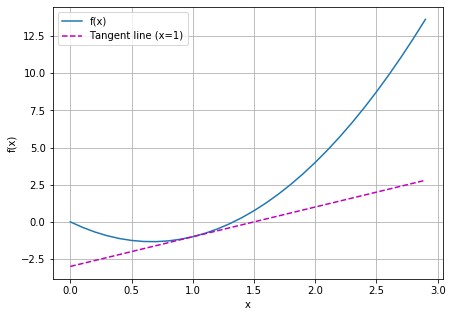

In [63]:
x = np.arange(0, 3, 0.1)
plot(x, [f(x), 2 * x - 3], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])

### 2.4.2 Partial Derivatives
So far we have dealt with the differentiation of functions of just one variable. In deep learning, functions often depend on many variables. Thus, we need to extend the ideas of differentiation to these multivariate functions.

Let $y = f(x_1, x_2, \ldots, x_n)$ be a function with $n$ variables. The partial derivative of $y$ with respect to its $i^\mathrm{th}$ parameter $x_i$ is

$$ \frac{\partial y}{\partial x_i} = \lim_{h \rightarrow 0} \frac{f(x_1, \ldots, x_{i-1}, x_i+h, x_{i+1}, \ldots, x_n) - f(x_1, \ldots, x_i, \ldots, x_n)}{h}.$$

To calculate $\frac{\partial y}{\partial x_i}$, we can simply treat $x_1, \ldots, x_{i-1}, x_{i+1}, \ldots, x_n$ as constants and calculate the derivative of $y$ with respect to $x_i$. For notation of partial derivatives, the following are equivalent:

$$\frac{\partial y}{\partial x_i} = \frac{\partial f}{\partial x_i} = f_{x_i} = f_i = D_i f = D_{x_i} f.$$

### 2.4.3 Gradients
We can concatenate partial derivatives of a multivariate function with respect to all its variables to obtain the gradient vector of the function. Suppose that the input of function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ is an $n$-dimensional vector $\mathbf{x} = [x_1, x_2, \ldots, x_n]^\top$ and the output is a scalar. The gradient of the function $f(\mathbf{x})$ with respect to $\mathbf{x}$ is a vector of $n$ partial derivatives:

$$\nabla_{\mathbf{x}} f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_n}\bigg]^\top,$$

where $\nabla_{\mathbf{x}} f(\mathbf{x})$ is often replaced by $\nabla f(\mathbf{x})$ when there is no ambiguity.

Let $\mathbf{x}$ be an $n$-dimensional vector, the following rules are often used when differentiating multivariate functions:
+ For all $\mathbf{A} \in \mathbb{R}^{m \times n}$, $\nabla_{\mathbf{x}} \mathbf{A} \mathbf{x} = \mathbf{A}^\top$
+ For all $\mathbf{A} \in \mathbb{R}^{n \times m}$, $\nabla_{\mathbf{x}} \mathbf{x}^\top \mathbf{A} = \mathbf{A}$
+ For all $\mathbf{A} \in \mathbb{R}^{n \times n}$, $\nabla_{\mathbf{x}} \mathbf{x}^\top \mathbf{A} \mathbf{x} = (\mathbf{A} + \mathbf{A}^\top)\mathbf{x}$
+ $\nabla_{\mathbf{x}} |\mathbf{x} |^2 = \nabla_{\mathbf{x}} \mathbf{x}^\top \mathbf{x} = 2\mathbf{x}$

Similarly, for any matrix $\mathbf{X}$, we have $\nabla_{\mathbf{X}} \Vert\mathbf{X} \Vert_F^2 = 2\mathbf{X}$. As we will see later, gradients are useful for designing optimization algorithms in deep learning.

### 2.4.4 Chain Rule
However, such gradients can be hard to find. This is because multivariate functions in deep learning are often composite, so we may not apply any of the aforementioned rules to differentiate these functions. Fortunately, the chain rule enables us to differentiate composite functions.

Let us first consider functions of a single variable. Suppose that functions $y=f(u)$ and $u=g(x)$ are both differentiable, then the chain rule states that

$$\frac{dy}{dx} = \frac{dy}{du} \frac{du}{dx}.$$

Now let us turn our attention to a more general scenario where functions have an arbitrary number of variables. Suppose that the differentiable function $y$ has variables $u_1, u_2, \ldots, u_m$, where each differentiable function $u_i$ has variables $x_1, x_2, \ldots, x_n$. Note that $y$ is a function of $x_1, x_2, \ldots, x_n$. Then the chain rule gives

$$\frac{dy}{dx_i} = \frac{dy}{du_1} \frac{du_1}{dx_i} + \frac{dy}{du_2} \frac{du_2}{dx_i} + \cdots + \frac{dy}{du_m} \frac{du_m}{dx_i}$$

for any $i = 1, 2, \ldots, n$.

##### Summary
+ Differential calculus and integral calculus are two branches of calculus, where the former can be applied to the ubiquitous optimization problems in deep learning.
+ A derivative can be interpreted as the instantaneous rate of change of a function with respect to its variable. It is also the slope of the tangent line to the curve of the function.
+ A gradient is a vector whose components are the partial derivatives of a multivariate function with respect to all its variables.
+ The chain rule enables us to differentiate composite functions.

##### Exercises
+ Plot the function $y = f(x) = x^3 - \frac{1}{x}$ and its tangent line when $x = 1$.
+ Find the gradient of the function $f(\mathbf{x}) = 3x_1^2 + 5e^{x_2}$.
+ What is the gradient of the function $f(\mathbf{x}) = |\mathbf{x}|_2$?
+ Can you write out the chain rule for the case where $u = f(x, y, z)$ and $x = x(a, b)$, $y = y(a, b)$, and $z = z(a, b)$?

##  2.5 Automatic Differentiation
As we have explained in `Section 2.4`, differentiation is a crucial step in nearly all deep learning optimization algorithms. While the calculations for taking these derivatives are straightforward, requiring only some basic calculus, for complex models, working out the updates by hand can be a pain (and often error-prone).

The autograd package expedites this work by automatically calculating derivatives, i.e., automatic differentiation. And while many other libraries require that we compile a symbolic graph to take automatic derivatives, autograd allows us to take derivatives while writing ordinary imperative code. Every time we pass data through our model, autograd builds a graph on the fly, tracking which data combined through which operations to produce the output. This graph enables autograd to subsequently backpropagate gradients on command. Here, backpropagate simply means to trace through the computational graph, filling in the partial derivatives with respect to each parameter.

### 2.5.1 A Simple Example
As a toy example, say that we are interested in differentiating the function $y = 2\mathbf{x}^{\top}\mathbf{x}$ with respect to the column vector $\mathbf{x}$. To start, let us create the variable x and assign it an initial value.

In [64]:
x = np.arange(4)
x

array([0., 1., 2., 3.])

Note that before we even calculate the gradient of $y$ with respect to $\mathbf{x}$, we will need a place to store it. It is important that we do not allocate new memory every time we take a derivative with respect to a parameter because we will often update the same parameters thousands or millions of times and could quickly run out of memory.

Note also that a gradient of a scalar-valued function with respect to a vector $\mathbf{x}$ is itself vector-valued and has the same shape as $\mathbf{x}$. Thus it is intuitive that in code, we will access a gradient taken with respect to $x$ as an attribute of the `ndarray` $x$ itself. We allocate memory for an `ndarray`'s gradient by invoking its `attach_grad` method.

In [65]:
x.attach_grad()

After we calculate a gradient taken with respect to $x$, we will be able to access it via the `grad` attribute. As a safe default, `x.grad` is initialized as an array containing all zeros. That is sensible because our most common use case for taking gradient in deep learning is to subsequently update parameters by adding (or subtracting) the gradient to maximize (or minimize) the differentiated function. By initializing the gradient to an array of zeros, we ensure that any update accidentally executed before a gradient has actually been calculated will not alter the parameters' value.

In [66]:
x.grad

array([0., 0., 0., 0.])

Now let us calculate $y$. Because we wish to subsequently calculate gradients, we want MXNet to generate a computational graph on the fly. We could imagine that MXNet would be turning on a recording device to capture the exact path by which each variable is generated.

Note that building the computational graph requires a nontrivial amount of computation. So MXNet will only build the graph when explicitly told to do so. We can invoke this behavior by placing our code inside an `autograd.record` scope.

In [67]:
with autograd.record():
    y = 2 * np.dot(x, x)
y

array(28.)

Next, we can automatically calculate the gradient of $y$ with respect to each component of $x$ by calling $y$'s backward function.

In [68]:
y.backward()

If we recheck the value of `x.grad`, we will find its contents overwritten by the newly calculated gradient.

In [69]:
x.grad

array([ 0.,  4.,  8., 12.])

The gradient of the function $y = 2\mathbf{x}^{\top}\mathbf{x}$ with respect to $\mathbf{x}$ should be $4\mathbf{x}$. Let us quickly verify that our desired gradient was calculated correctly. 

In [70]:
x.grad == 4 * x

array([ True,  True,  True,  True])

If we subsequently compute the gradient of another variable whose value was calculated as a function of $x$, the contents of `x.grad` will be overwritten.

In [71]:
with autograd.record():
    y = x.sum()
y.backward()
x.grad

array([1., 1., 1., 1.])

### 2.5.2 Backward for Non-Scalar Variables
Technically, when $y$ is not a scalar, the most natural interpretation of the differentiation of a vector $y$ with respect to a vector $x$ is a matrix. For higher-order and higher-dimensional $y$ and $x$, the differentiation result could be a gnarly high-order tensor.

However, while these more exotic objects do show up in advanced machine learning (including in deep learning), more often when we are calling backward on a vector, we are trying to calculate the derivatives of the loss functions for each constituent of a batch of training examples. Here, our intent is not to calculate the differentiation matrix but rather the sum of the partial derivatives computed individually for each example in the batch.

Thus when we invoke backward on a vector-valued variable $y$, which is a function of $x$, MXNet assumes that we want the sum of the gradients. In short, MXNet will create a new scalar variable by summing the elements in $y$, and compute the gradient of that scalar variable with respect to $x$.

In [72]:
with autograd.record():
    y = x * x  # y is a vector
y.backward()

u = x.copy()
u.attach_grad()
with autograd.record():
    v = (u * u).sum()  # v is a scalar
v.backward()

x.grad == u.grad

array([ True,  True,  True,  True])

### 2.5.3 Detaching Computation
Sometimes, we wish to move some calculations outside of the recorded computational graph. For example, say that $y$ was calculated as a function of $x$, and that subsequently $z$ was calculated as a function of both $y$ and $x$. Now, imagine that we wanted to calculate the gradient of $z$ with respect to $x$, but wanted for some reason to treat $y$ as a constant, and only take into account the role that $x$ played after $y$ was calculated.

Here, we can call `u = y.detach()` to return a new variable $u$ that has the same value as $y$ but discards any information about how $y$ was computed in the computational graph. In other words, the gradient will not flow backwards through $u$ to $x$. This will provide the same functionality as if we had calculated $u$ as a function of $x$ outside of the `autograd.record` scope, yielding a $u$ that will be treated as a constant in any backward call. Thus, the following backward function computes the partial derivative of $z = u * x$ with respect to $x$ while treating $u$ as a constant, instead of the partial derivative of $z = x * x * x$ with respect to $x$.

In [73]:
with autograd.record():
    y = x * x
    u = y.detach()
    z = u * x
z.backward()
x.grad == u

array([ True,  True,  True,  True])

Since the computation of $y$ was recorded, we can subsequently call `y.backward()` to get the derivative of $y = x * x$ with respect to $x$, which is $2 * x$.

In [74]:
y.backward()
x.grad == 2 * x

array([ True,  True,  True,  True])

Note that attaching gradients to a variable $x$ implicitly calls `x = x.detach()`. If $x$ is computed based on other variables, this part of computation will not be used in the backward function.

In [75]:
y = np.ones(4) * 2
y.attach_grad()
with autograd.record():
    u = x * y
    u.attach_grad()  # Implicitly run u = u.detach()
    z = 5 * u - x
z.backward()
x, y, x.grad, u.grad, y.grad

(array([0., 1., 2., 3.]),
 array([2., 2., 2., 2.]),
 array([-1., -1., -1., -1.]),
 array([5., 5., 5., 5.]),
 array([0., 0., 0., 0.]))

### 2.5.4 Computing the Gradient of Python Control Flow
One benefit of using automatic differentiation is that even if building the computational graph of a function required passing through a maze of Python control flow (e.g., conditionals, loops, and arbitrary function calls), we can still calculate the gradient of the resulting variable. In the following snippet, note that the number of iterations of the while loop and the evaluation of the if statement both depend on the value of the input $a$.

In [76]:
def f(a):
    b = a * 2
    while np.linalg.norm(b) < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

Again to compute gradients, we just need to record the calculation and then call the backward function.

In [77]:
a = np.random.normal()
a.attach_grad()
with autograd.record():
    d = f(a)
d.backward()

We can now analyze the $f$ function defined above. Note that it is piecewise linear in its input $a$. In other words, for any $a$ there exists some constant scalar $k$ such that $f(a) = k * a$, where the value of $k$ depends on the input $a$. Consequently $\frac{d}{a}$ allows us to verify that the gradient is correct.

In [78]:
a.grad == d / a

array(True)

### 2.5.5 Training Mode and Prediction Mode
As we have seen, after we call `autograd.record`, MXNet logs the operations in the following block. There is one more subtle detail to be aware of. Additionally, `autograd.record` will change the running mode from prediction mode to training mode. We can verify this behavior by calling the `is_training` function.

In [79]:
print(autograd.is_training())
with autograd.record():
    print(autograd.is_training())

False
True


When we get to complicated deep learning models, we will encounter some algorithms where the model behaves differently during training and when we subsequently use it to make predictions. We will cover these differences in detail in later chapters.

##### Summary
+ MXNet provides the `autograd` package to automate the calculation of derivatives. To use it, we first attach gradients to those variables with respect to which we desire partial derivatives. We then record the computation of our target value, execute its `backward` function, and access the resulting gradient via our variable's `grad` attribute.
+ We can detach gradients to control the part of the computation that will be used in the `backward` function.
+ The running modes of MXNet include training mode and prediction mode. We can determine the running mode by calling the `is_training` function.

##### Exercises
+ Why is the second derivative much more expensive to compute than the first derivative?
+ After running `y.backward()`, immediately run it again and see what happens.
+ In the control flow example where we calculate the derivative of $d$ with respect to $a$, what would happen if we changed the variable $a$ to a random vector or matrix. At this point, the result of the calculation $f(a)$ is no longer a scalar. What happens to the result? How do we analyze this?
+ Redesign an example of finding the gradient of the control flow. Run and analyze the result.
+ Let $f(x) = \sin(x)$. Plot $f(x)$ and $\frac{df(x)}{dx}$, where the latter is computed without exploiting that $f'(x) = \cos(x)$.
+ In a second-price auction (such as in eBay or in computational advertising), the winning bidder pays the second-highest price. Compute the gradient of the final price with respect to the winning bidder's bid using autograd. What does the result tell you about the mechanism? If you are curious to learn more about second-price auctions, check out the paper by Edelman et al((Edelman et al., 2007).).

## 2.6 Probability
In some form or another, machine learning is all about making predictions. We might want to predict the probability of a patient suffering a heart attack in the next year, given their clinical history. In anomaly detection, we might want to assess how likely a set of readings from an airplane's jet engine would be, were it operating normally. In reinforcement learning, we want an agent to act intelligently in an environment. This means we need to think about the probability of getting a high reward under each of the available actions. And when we build recommender systems we also need to think about probability. For example, say hypothetically that we worked for a large online bookseller. We might want to estimate the probability that a particular user would buy a particular book. For this we need to use the language of probability. Entire courses, majors, theses, careers, and even departments, are devoted to probability. So naturally, our goal in this section is not to teach the whole subject. Instead we hope to get you off the ground, to teach you just enough that you can start building your first deep learning models, and to give you enough of a flavor for the subject that you can begin to explore it on your own if you wish.

We have already invoked probabilities in previous sections without articulating what precisely they are or giving a concrete example. Let us get more serious now by considering the first case: distinguishing cats and dogs based on photographs. This might sound simple but it is actually a formidable challenge. To start with, the difficulty of the problem may depend on the resolution of the image.

<img src="images/02_02.png" style="width:600px;"/>

As shown in `Fig 2.6.1`, while it is easy for humans to recognize cats and dogs at the resolution of $160 \times 160$ pixels, it becomes challenging at $40 \times 40$ pixels and next to impossible at $10 \times 10$ pixels. In other words, our ability to tell cats and dogs apart at a large distance (and thus low resolution) might approach uninformed guessing. Probability gives us a formal way of reasoning about our level of certainty:
+ If we are completely sure that the image depicts a cat, we say that the probability that the corresponding label $y$ is "cat", denoted $P(y=$ "cat"$)$ equals $1$
+ If we had no evidence to suggest that $y =$ "cat" or that $y =$ "dog", then we might say that the two possibilities were equally likely expressing this as $P(y=$ "cat"$) = P(y=$ "dog"$) = 0.5$
+ If we were reasonably confident, but not sure that the image depicted a cat, we might assign a probability $0.5 < P(y=$ "cat"$) < 1$

Now consider the second case: given some weather monitoring data, we want to predict the probability that it will rain in Taipei tomorrow. If it is summertime, the rain might come with probability $0.5$.

In both cases, we have some value of interest. And in both cases we are uncertain about the outcome. But there is a key difference between the two cases. In this first case, the image is in fact either a dog or a cat, and we just do not know which. In the second case, the outcome may actually be a random event, if you believe in such things (and most physicists do). So probability is a flexible language for reasoning about our level of certainty, and it can be applied effectively in a broad set of contexts.

### 2.6.1 Basic Probability Theory
Say that we cast a die and want to know what the chance is of seeing a $1$ rather than another digit. If the die is fair, all the $6$ outcomes ${1, \ldots, 6}$ are equally likely to occur, and thus we would see a $1$ in one out of six cases. Formally we state that $1$ occurs with probability $\frac{1}{6}$.

For a real die that we receive from a factory, we might not know those proportions and we would need to check whether it is tainted. The only way to investigate the die is by casting it many times and recording the outcomes. For each cast of the die, we will observe a value in ${1, \ldots, 6}$. Given these outcomes, we want to investigate the probability of observing each outcome.

One natural approach for each value is to take the individual count for that value and to divide it by the total number of tosses. This gives us an estimate of the probability of a given event. `The law of large numbers` tell us that as the number of tosses grows this estimate will draw closer and closer to the true underlying probability. Before going into the details of what is going here, let us try it out.

In statistics we call this process of drawing examples from probability `distributions sampling`. The distribution that assigns probabilities to a number of discrete choices is called the `multinomial distribution`. We will give a more formal definition of distribution later, but at a high level, think of it as just an assignment of probabilities to events. In MXNet, we can sample from the multinomial distribution via the aptly named `np.random.multinomial` function. The function can be called in many ways, but we will focus on the simplest. To draw a single sample, we simply pass in a vector of probabilities. The output of the `np.random.multinomial` function is another vector of the same length: its value at index $i$ is the number of times the sampling outcome corresponds to $i$.

In [80]:
fair_probs = [1.0 / 6] * 6
np.random.multinomial(1, fair_probs)

array([1, 0, 0, 0, 0, 0], dtype=int64)

If you run the sampler a bunch of times, you will find that you get out random values each time. As with estimating the fairness of a die, we often want to generate many samples from the same distribution. It would be unbearably slow to do this with a Python for loop, so `random.multinomial` supports drawing multiple samples at once, returning an array of independent samples in any shape we might desire.

In [81]:
np.random.multinomial(10, fair_probs)

array([1, 0, 3, 2, 2, 2], dtype=int64)

We can also conduct, say, $3$ groups of experiments, where each group draws $10$ samples, all at once.

In [84]:
counts = np.random.multinomial(10, fair_probs, size=3)
counts

array([[1, 3, 2, 1, 1, 2],
       [2, 1, 0, 2, 0, 5],
       [5, 2, 1, 0, 0, 2]], dtype=int64)

Now that we know how to sample rolls of a die, we can simulate 1000 rolls. We can then go through and count, after each of the 1000 rolls, how many times each number was rolled. Specifically, we calculate the relative frequency as the estimate of the true probability.

In [85]:
# Store the results as 32-bit floats for division
counts = np.random.multinomial(1000, fair_probs).astype(np.float32)
counts / 1000  # Relative frequency as the estimate

array([0.17 , 0.175, 0.177, 0.163, 0.166, 0.149])

Because we generated the data from a fair die, we know that each outcome has true probability $\frac{1}{6}$, roughly $0.167$, so the above output estimates look good.

Let us conduct $500$ groups of experiments where each group draws $10$ samples.

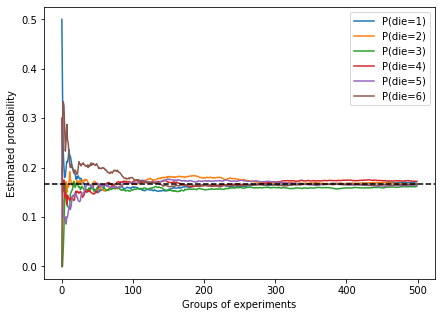

In [88]:
counts = np.random.multinomial(10, fair_probs, size=500)
cum_counts = counts.astype(np.float32).cumsum(axis=0)
estimates = cum_counts / cum_counts.sum(axis=1, keepdims=True)

for i in range(6):
    plt.plot(estimates[:, i].asnumpy(), label=("P(die=" + str(i + 1) + ")"))
plt.axhline(y=0.167, color='black', linestyle='dashed')
plt.gca().set_xlabel('Groups of experiments')
plt.gca().set_ylabel('Estimated probability')
plt.legend()
plt.show()

Each solid curve corresponds to one of the six values of the die and gives our estimated probability that the die turns up that value as assessed after each group of experiments. The dashed black line gives the true underlying probability. As we get more data by conducting more experiments, the $6$ solid curves converge towards the true probability.

##### Axioms of Probability Theory
When dealing with the rolls of a die, we call the set $\mathcal{S} = {1, 2, 3, 4, 5, 6}$ the sample space or outcome space, where each element is an outcome. An event is a set of outcomes from a given sample space. For instance, "seeing a $5$" (${5}$) and "seeing an odd number" (${1, 3, 5}$) are both valid events of rolling a die. Note that if the outcome of a random experiment is in event $\mathcal{A}$, then event $\mathcal{A}$ has occurred. That is to say, if $3$ dots faced up after rolling a die, since $3 \in {1, 3, 5}$, we can say that the event "seeing an odd number" has occurred.

Formally, probability can be thought of a function that maps a set to a real value. The probability of an event $\mathcal{A}$ in the given sample space $\mathcal{S}$, denoted as $P(\mathcal{A})$, satisfies the following properties:

For any event $\mathcal{A}$, its probability is never negative, i.e., $P(\mathcal{A}) \geq 0$;
Probability of the entire sample space is $1$, i.e., $P(\mathcal{S}) = 1$;
For any countable sequence of events $\mathcal{A}_1, \mathcal{A}_2, \ldots$ that are mutually exclusive ($\mathcal{A}_i \cap \mathcal{A}j = \emptyset$ for all $i \neq j$), the probability that any happens is equal to the sum of their individual probabilities, i.e., $P(\bigcup{i=1}^{\infty} \mathcal{A}i) = \sum{i=1}^{\infty} P(\mathcal{A}_i)$.
These are also the axioms of probability theory, proposed by Kolmogorov in 1933. Thanks to this axiom system, we can avoid any philosophical dispute on randomness; instead, we can reason rigorously with a mathematical language. For instance, by letting event $\mathcal{A}_1$ be the entire sample space and $\mathcal{A}_i = \emptyset$ for all $i > 1$, we can prove that $P(\emptyset) = 0$, i.e., the probability of an impossible event is $0$.

##### Random Variables
In our random experiment of casting a die, we introduced the notion of a random variable. A random variable can be pretty much any quantity and is not deterministic. It could take one value among a set of possibilities in a random experiment. Consider a random variable $X$ whose value is in the sample space $\mathcal{S} = {1, 2, 3, 4, 5, 6}$ of rolling a die. We can denote the event "seeing a $5$" as ${X = 5}$ or $X = 5$, and its probability as $P({X = 5})$ or $P(X = 5)$. By $P(X = a)$, we make a distinction between the random variable $X$ and the values (e.g., $a$) that $X$ can take. However, such pedantry results in a cumbersome notation. For a compact notation, on one hand, we can just denote $P(X)$ as the distribution over the random variable $X$: the distribution tells us the probability that $X$ takes any value. On the other hand, we can simply write $P(a)$ to denote the probability that a random variable takes the value $a$. Since an event in probability theory is a set of outcomes from the sample space, we can specify a range of values for a random variable to take. For example, $P(1 \leq X \leq 3)$ denotes the probability of the event ${1 \leq X \leq 3}$, which means ${X = 1, 2, \text{or}, 3}$. Equivalently, $P(1 \leq X \leq 3)$ represents the probability that the random variable $X$ can take a value from ${1, 2, 3}$.

Note that there is a subtle difference between discrete random variables, like the sides of a die, and continuous ones, like the weight and the height of a person. There is little point in asking whether two people have exactly the same height. If we take precise enough measurements you will find that no two people on the planet have the exact same height. In fact, if we take a fine enough measurement, you will not have the same height when you wake up and when you go to sleep. So there is no purpose in asking about the probability that someone is $1.80139278291028719210196740527486202$ meters tall. Given the world population of humans the probability is virtually $0$. It makes more sense in this case to ask whether someone's height falls into a given interval, say between $1.79$ and $1.81$ meters. In these cases we quantify the likelihood that we see a value as a density. The height of exactly $1.80$ meters has no probability, but nonzero density. In the interval between any two different heights we have nonzero probability. In the rest of this section, we consider probability in discrete space. For probability over continuous random variables, you may refer to :numref:sec_random_variables.

### 2.6.2 Dealing with Multiple Random Variables
Very often, we will want to consider more than one random variable at a time. For instance, we may want to model the relationship between diseases and symptoms. Given a disease and a symptom, say "flu" and "cough", either may or may not occur in a patient with some probability. While we hope that the probability of both would be close to zero, we may want to estimate these probabilities and their relationships to each other so that we may apply our inferences to effect better medical care.

As a more complicated example, images contain millions of pixels, thus millions of random variables. And in many cases images will come with a label, identifying objects in the image. We can also think of the label as a random variable. We can even think of all the metadata as random variables such as location, time, aperture, focal length, ISO, focus distance, and camera type. All of these are random variables that occur jointly. When we deal with multiple random variables, there are several quantities of interest.

##### Joint Probability
The first is called the joint probability $P(A = a, B=b)$. Given any values $a$ and $b$, the joint probability lets us answer, what is the probability that $A=a$ and $B=b$ simultaneously? Note that for any values $a$ and $b$, $P(A=a, B=b) \leq P(A=a)$. This has to be the case, since for $A=a$ and $B=b$ to happen, $A=a$ has to happen and $B=b$ also has to happen (and vice versa). Thus, $A=a$ and $B=b$ cannot be more likely than $A=a$ or $B=b$ individually.

##### Conditional Probability
This brings us to an interesting ratio: $0 \leq \frac{P(A=a, B=b)}{P(A=a)} \leq 1$. We call this ratio a conditional probability and denote it by $P(B=b \mid A=a)$: it is the probability of $B=b$, provided that $A=a$ has occurred.

##### Bayes theorem
Using the definition of conditional probabilities, we can derive one of the most useful and celebrated equations in statistics: Bayes' theorem. It goes as follows. By construction, we have the multiplication rule that $P(A, B) = P(B \mid A) P(A)$. By symmetry, this also holds for $P(A, B) = P(A \mid B) P(B)$. Assume that $P(B) > 0$. Solving for one of the conditional variables we get

$$P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}.$$

Note that here we use the more compact notation where $P(A, B)$ is a joint distribution and $P(A \mid B)$ is a conditional distribution. Such distributions can be evaluated for particular values $A = a, B=b$.

##### Marginalization
Bayes' theorem is very useful if we want to infer one thing from the other, say cause and effect, but we only know the properties in the reverse direction, as we will see later in this section. One important operation that we need, to make this work, is marginalization. It is the operation of determining $P(B)$ from $P(A, B)$. We can see that the probability of $B$ amounts to accounting for all possible choices of $A$ and aggregating the joint probabilities over all of them:

$$P(B) = \sum_{A} P(A, B),$$

which is also known as the sum rule. The probability or distribution as a result of marginalization is called a marginal probability or a marginal distribution.

##### Independence
Another useful property to check for is dependence vs. independence. Two random variables $A$ and $B$ being independent means that the occurrence of one event of $A$ does not reveal any information about the occurrence of an event of $B$. In this case $P(B \mid A) = P(B)$. Statisticians typically express this as $A \perp B$. From Bayes' theorem, it follows immediately that also $P(A \mid B) = P(A)$. In all the other cases we call $A$ and $B$ dependent. For instance, two successive rolls of a die are independent. In contrast, the position of a light switch and the brightness in the room are not (they are not perfectly deterministic, though, since we could always have a broken light bulb, power failure, or a broken switch).

Since $P(A \mid B) = \frac{P(A, B)}{P(B)} = P(A)$ is equivalent to $P(A, B) = P(A)P(B)$, two random variables are independent if and only if their joint distribution is the product of their individual distributions. Likewise, two random variables $A$ and $B$ are conditionally independent given another random variable $C$ if and only if $P(A, B \mid C) = P(A \mid C)P(B \mid C)$. This is expressed as $A \perp B \mid C$.

##### Application
Let us put our skills to the test. Assume that a doctor administers an AIDS test to a patient. This test is fairly accurate and it fails only with $1\%$ probability if the patient is healthy but reporting him as diseased. Moreover,
it never fails to detect HIV if the patient actually has it. We use $D_1$ to indicate the diagnosis ($1$ if positive and $0$ if negative) and $H$ to denote the HIV status ($1$ if positive and $0$ if negative).
:numref:`conditional_prob_D1` lists such conditional probabilities.

:Conditional probability of $P(D_1 \mid H)$.

| Conditional probability | $H=1$ | $H=0$ |
|---|---|---|
|$P(D_1 = 1 \mid H)$|            1 |         0.01 |
|$P(D_1 = 0 \mid H)$|            0 |         0.99 |
:label:`conditional_prob_D1`

Note that the column sums are all $1$ (but the row sums are not), since the conditional probability needs to sum up to $1$, just like the probability. Let us work out the probability of the patient having AIDS if the test comes back positive, i.e., $P(H = 1 \mid D_1 = 1)$. Obviously this is going to depend on how common the disease is, since it affects the number of false alarms. Assume that the population is quite healthy, e.g., $P(H=1) = 0.0015$. To apply Bayes' theorem, we need to apply marginalization and the multiplication rule to determine

$$\begin{aligned}
&P(D_1 = 1) \\
=& P(D_1=1, H=0) + P(D_1=1, H=1)  \\
=& P(D_1=1 \mid H=0) P(H=0) + P(D_1=1 \mid H=1) P(H=1) \\
=& 0.011485.
\end{aligned}
$$

Thus, we get

$$\begin{aligned}
&P(H = 1 \mid D_1 = 1)\\ =& \frac{P(D_1=1 \mid H=1) P(H=1)}{P(D_1=1)} \\ =& 0.1306 \end{aligned}.$$

In other words, there is only a 13.06% chance that the patient
actually has AIDS, despite using a very accurate test. 
As we can see, probability can be counterintuitive.

What should a patient do upon receiving such terrifying news? Likely, the patient
would ask the physician to administer another test to get clarity. The second
test has different characteristics and it is not as good as the first one, as shown in :numref:`conditional_prob_D2`.


:Conditional probability of $P(D_2 \mid H)$.

| Conditional probability | $H=1$ | $H=0$ |
|---|---|---|
|$P(D_2 = 1 \mid H)$|            0.98 |         0.03 |
|$P(D_2 = 0 \mid H)$|            0.02 |         0.97 |
:label:`conditional_prob_D2`

Unfortunately, the second test comes back positive, too. 
Let us work out the requisite probabilities to invoke Bayes' theorem 
by assuming the conditional independence:

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1 \mid H = 0) \\
=& P(D_1 = 1 \mid H = 0) P(D_2 = 1 \mid H = 0)  \\
=& 0.0003,
\end{aligned}
$$

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1 \mid H = 1) \\
=& P(D_1 = 1 \mid H = 1) P(D_2 = 1 \mid H = 1)  \\
=& 0.98.
\end{aligned}
$$

Now we can apply marginalization and the multiplication rule:

$$\begin{aligned}
&P(D_1 = 1, D_2 = 1) \\
=& P(D_1 = 1, D_2 = 1, H = 0) + P(D_1 = 1, D_2 = 1, H = 1)  \\
=& P(D_1 = 1, D_2 = 1 \mid H = 0)P(H=0) + P(D_1 = 1, D_2 = 1 \mid H = 1)P(H=1)\\
=& 0.00176955.
\end{aligned}
$$

In the end, the probability of the patient having AIDS given both positive tests is

$$\begin{aligned}
&P(H = 1 \mid D_1 = 1, D_2 = 1)\\
=& \frac{P(D_1 = 1, D_2 = 1 \mid H=1) P(H=1)}{P(D_1 = 1, D_2 = 1)} \\
=& 0.8307.
\end{aligned}
$$

That is, the second test allowed us to gain much higher confidence that not all is well. Despite the second test being considerably less accurate than the first one, it still significantly improved our estimate.



### 2.6.3Expectation and Variance
To summarize key characteristics of probability distributions,
we need some measures.
The *expectation* (or average) of the random variable $X$ is denoted as

$$E[X] = \sum_{x} x P(X = x).$$

When the input of a function $f(x)$ is a random variable drawn from the distribution $P$ with different values $x$,
the expectation of $f(x)$ is computed as

$$E_{x \sim P}[f(x)] = \sum_x f(x) P(x).$$


In many cases we want to measure by how much the random variable $X$ deviates from its expectation. This can be quantified by the variance

$$\mathrm{Var}[X] = E\left[(X - E[X])^2\right] =
E[X^2] - E[X]^2.$$

Its square root is called the *standard deviation*.
The variance of a function of a random variable measures
by how much the function deviates from the expectation of the function,
as different values $x$ of the random variable are sampled from its distribution:

$$\mathrm{Var}[f(x)] = E\left[\left(f(x) - E[f(x)]\right)^2\right].$$


##### Summary
+ We can use MXNet to sample from probability distributions.
+ We can analyze multiple random variables using joint distribution, conditional distribution, Bayes' theorem, marginalization, and independence assumptions.
+ Expectation and variance offer useful measures to summarize key characteristics of probability distributions.


##### Exercises
+ We conducted $m=500$ groups of experiments where each group draws $n=10$ samples. Vary $m$ and $n$. Observe and analyze the experimental results.
+ Given two events with probability $P(\mathcal{A})$ and $P(\mathcal{B})$, compute upper and lower bounds on $P(\mathcal{A} \cup \mathcal{B})$ and $P(\mathcal{A} \cap \mathcal{B})$. (Hint: display the situation using a [Venn Diagram](https://en.wikipedia.org/wiki/Venn_diagram).)
+ Assume that we have a sequence of random variables, say $A$, $B$, and $C$, where $B$ only depends on $A$, and $C$ only depends on $B$, can you simplify the joint probability $P(A, B, C)$? (Hint: this is a [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain).)
+ In :numref:`subsec_probability_hiv_app`, the first test is more accurate. Why not just run the first test a second time?